In [ ]:
################################################################################
######################  Lending Tree Loan Status  ##############################
######################   Classification - Linear  ##############################
######################         HPO GPU            ##############################
################################################################################

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/LoanStatus/ML/RAPIDS/

/content/drive/MyDrive/LoanStatus/ML/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,867 kB]
Get:13 http://archive.ubuntu

In [3]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:32
🔁 Restarting kernel...


In [3]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [4]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [5]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
!pip install plotly
import os
import random
import time
from contextlib import contextmanager
import numpy as np
import cupy 
import cudf
import cuml
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask, dask_cudf
from dask.diagnostics import ProgressBar
import dask_optuna
import urllib.request
from cuml.preprocessing import train_test_split
from cuml.linear_model import LogisticRegression
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import joblib
from joblib import parallel_backend
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import warnings
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

my_dpi=96

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 40.7 MB/s 
     |████████████████████████████████| 209 kB 57.0 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 150 kB 64.4 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 39.2 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 146 kB 65.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=bf25fd04e4c07d40a69677530a45e7a9bc142de0ace3d0b2fa37400cc99a89b8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [6]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://172.28.0.2:8081/status,
Dashboard: http://172.28.0.2:8081/status,Workers: 1
Total threads: 1,Total memory: 25.46 GiB
Status: running,Using processes: True
Comm: tcp://172.28.0.2:33595,Workers: 1
Dashboard: http://172.28.0.2:8081/status,Total threads: 1
Started: Just now,Total memory: 25.46 GiB
Comm: tcp://172.28.0.2:33445,Total threads: 1
Dashboard: http://172.28.0.2:38977/status,Memory: 25.46 GiB
Nanny: tcp://172.28.0.2:38635,


In [7]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [8]:
# Set seed 
seed_value = 42
os.environ['Linear_GPU'] = str(seed_value)
cupy.random.seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [9]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [10]:
# Read data
trainDF = cudf.read_csv('trainDF_US.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF  = cudf.read_csv('testDF_US.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [11]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)

# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [12]:
################################################################################
######################         F1 Weighted        ##############################
######################         1000 Trials        ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_lr_optuna_US_1000_weightedF1_tpe'

In [14]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [15]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=1e6, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted F1 score of the fitted model
    '''    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    
    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                   C=C, max_iter=max_iter, linesearch_max_iter=linesearch_max_iter, 
                   l1_ratio=l1_ratio, solver=solver, 
                   fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = f1_score(y_test.to_numpy(), y_pred.to_numpy(), average='weighted')
    
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [16]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 13.045647841999653
- Trial weighted F1: 0.9615002591245148
######################################################
Score with default parameters :  0.9615002591245148


In [17]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Logistic_Optuna_US_1000_GPU_F1weighted.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [18]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_US_1000_GPU_F1weighted.pkl'): 
        study = joblib.load('Logistic_Optuna_US_1000_GPU_F1weighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-07-02 21:15:55.337716
- Trial time: 0.29800780499999746
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.4512721060000331
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 1.2098761289998947
- Trial weighted F1: 0.9571130180288807
######################################################
- Trial time: 0.29390638399991076
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.3164937810001902
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.3655462950000583
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.3920360540000729
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 1.7214524149999306
- Trial weighted F1: 

In [37]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [38]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

trials_df = trials_df.sort_values('f1_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Logistic_Optuna_US_1000_GPU_weightedF1.csv', index=False)

     iteration  f1_weighted             datetime_start  \
332        332     0.961758 2022-07-02 21:48:35.252759   
928        928     0.961697 2022-07-02 22:53:09.094272   
658        658     0.961688 2022-07-02 22:23:20.603543   
373        373     0.961685 2022-07-02 21:52:38.804943   
698        698     0.961685 2022-07-02 22:28:01.981427   
..         ...          ...                        ...   
322        322     0.814795 2022-07-02 21:47:46.733027   
326        326     0.814795 2022-07-02 21:48:10.142698   
80          80     0.814795 2022-07-02 21:21:39.205700   
839        839     0.814795 2022-07-02 22:43:34.810750   
0            0     0.814795 2022-07-02 21:15:55.347864   

             datetime_complete               duration    C  l1_ratio  \
332 2022-07-02 21:48:43.464346 0 days 00:00:08.211587  0.1  0.079188   
928 2022-07-02 22:53:16.956258 0 days 00:00:07.861986  0.1  0.582743   
658 2022-07-02 22:23:29.396678 0 days 00:00:08.793135  0.4  0.077961   
373 2022-07-02 

In [39]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [40]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_US_1000_GPU_weightedF1.html')
fig.show()

In [41]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_US_1000_GPU_weightedF1.html')
fig.show()

In [42]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_US_1000_GPU_weightedF1.html')
fig.show()

In [47]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_US_1000_GPU_weightedF1.html')
fig.show()

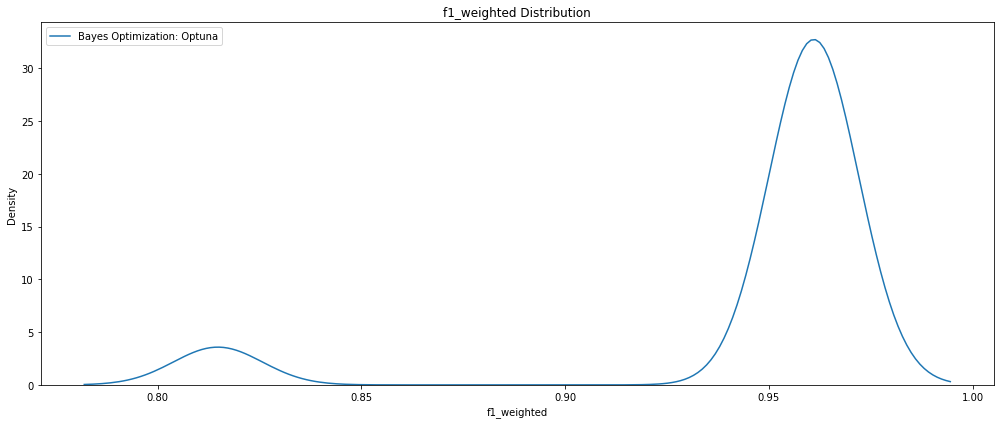

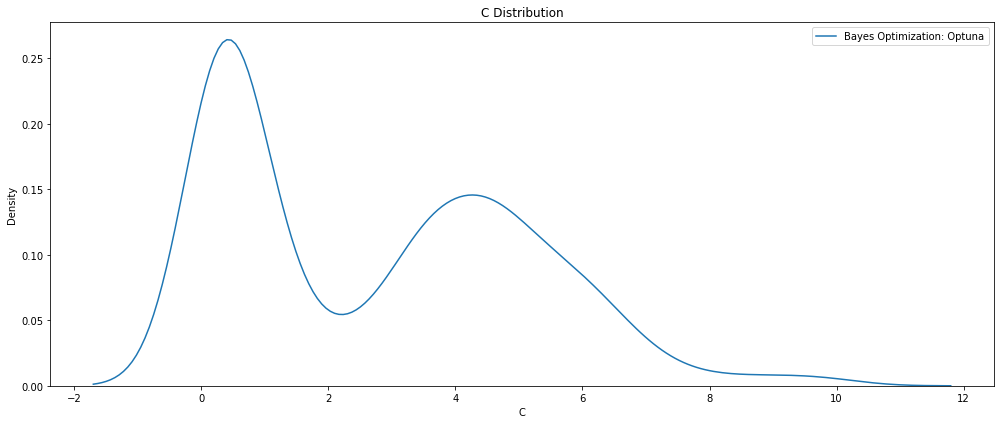

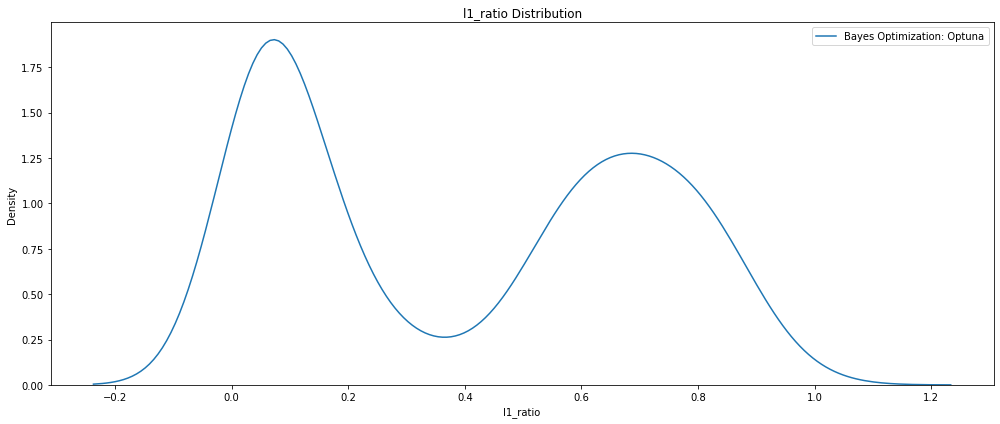

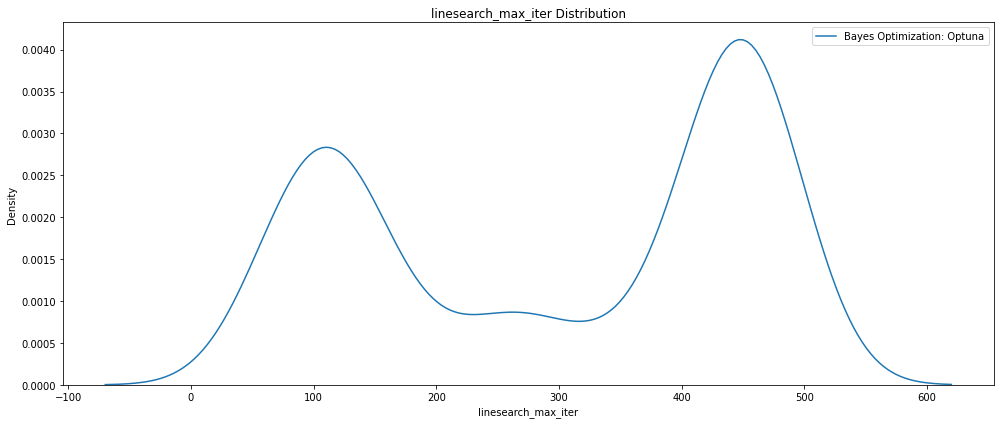

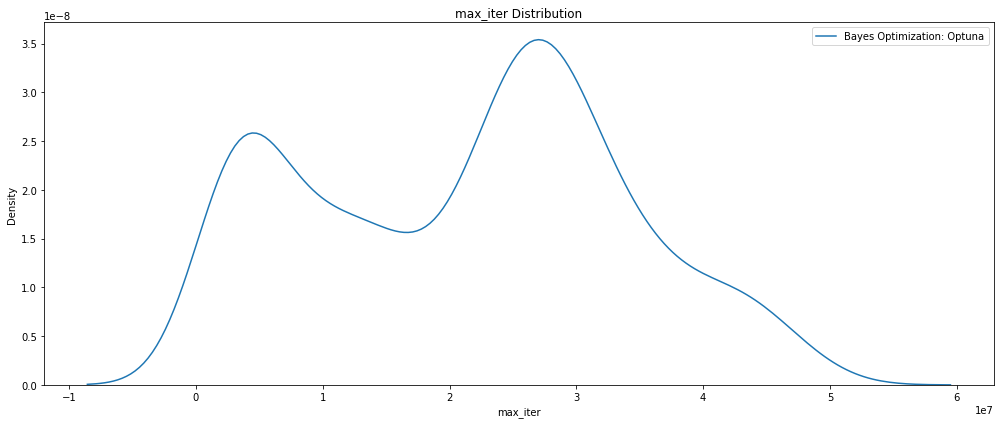

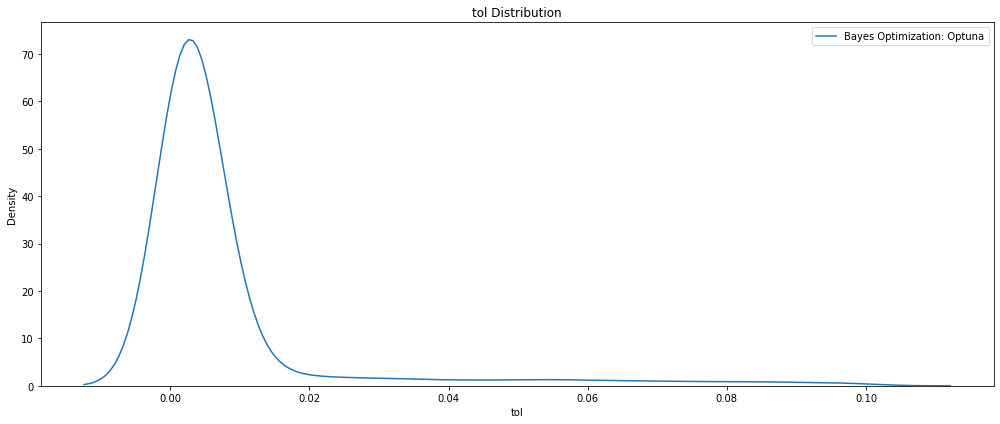

In [58]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [56]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_US_1000_GPU_weightedF1.html')
fig.show()

In [57]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_US_1000_GPU_weightedF1.html')
fig.show()

In [59]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 0.1,
 'l1_ratio': 0.07918776059073956,
 'linesearch_max_iter': 125,
 'max_iter': 30180412,
 'penalty': 'l1',
 'tol': 0.00014707012140658597}

In [60]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [61]:
# Set up train/test split
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [62]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)
    
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [63]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [64]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_US_trials1000_GPU_F1weighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_US_trials1000_GPU_F1weighted.pkl')
# print(model)
# =============================================================================

In [65]:
print('\nModel Metrics for Logistic HPO Upsampling 1000 trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO Upsampling 1000 trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    377848
           1       0.82      0.88      0.85     54625

    accuracy                           0.96    432473
   macro avg       0.90      0.93      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[367553  10295]
 [  6489  48136]]


Accuracy score : 0.961
Precision score : 0.824
Recall score : 0.881
F1 score : 0.852


In [66]:
# Evaluate on the testing data 
print('The best model from Upsampling 1000 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 1000 GPU trials optimization scores 0.92698 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     332
f1_weighted                              0.961758
datetime_start         2022-07-02 21:48:35.252759
datetime_complete      2022-07-02 21:48:43.464346
duration                   0 days 00:00:08.211587
C                                             0.1
l1_ratio                                 0.079188
linesearch_max_iter                           125
max_iter                                 30180412
penalty                                        l1
tol                                      0.000147
state                                    COMPLETE
Name: 332, dtype: object


In [67]:
################################################################################
######################         ROC Weighted       ##############################
######################         1000 Trials        ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_lr_optuna_US_1000_weightedROC_tpe'

In [75]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [76]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=10000, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted ROC score of the fitted model
    '''    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    
    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                   C=C, max_iter=max_iter, linesearch_max_iter=linesearch_max_iter, 
                   l1_ratio=l1_ratio, solver=solver, 
                   fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test.to_numpy(), y_pred.to_numpy(), 
                          average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [70]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 7.331230495001364
- Trial weighted ROC: 0.9274262482844554
######################################################
Score with default parameters :  0.9274262482844554


In [73]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Logistic_Optuna_US_1000_GPU_ROCweighted.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)    
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [77]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_US_1000_GPU_ROCweighted.pkl'): 
        study = joblib.load('Logistic_Optuna_US_1000_GPU_ROCweighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted', study.best_value)

Start Time           2022-07-02 23:30:46.509222
- Trial time: 1.1250094220013125
- Trial weighted ROC: 0.9329006628263143
######################################################
- Trial time: 0.24312435899992124
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.2375163770011568
- Trial weighted ROC: 0.5
######################################################
- Trial time: 1.1105283910001162
- Trial weighted ROC: 0.9328993395428777
######################################################
- Trial time: 0.24576794499989774
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.7808106239990593
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.2445878280013858
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.24041443699934462
- Trial weighted ROC: 0.5
######################################################
- Trial

In [104]:
study = joblib.load('Logistic_Optuna_US_1000_GPU_ROCweighted.pkl')

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted', study.best_value)

Number of finished trials: 1001
Best trial: {'penalty': 'l1', 'tol': 0.03671495015853522, 'C': 6.4, 'max_iter': 15536062, 'linesearch_max_iter': 79, 'l1_ratio': 0.9873827946567323}
Highest ROCweighted 0.9330856080928891


In [103]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [78]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [79]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

trials_df = trials_df.sort_values('roc_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Logistic_Optuna_US_1000_GPU_ROCweighted.csv', index=False)

     iteration  roc_weighted             datetime_start  \
450        450      0.933086 2022-07-02 23:42:17.587332   
480        480      0.933086 2022-07-02 23:43:14.242655   
422        422      0.933086 2022-07-02 23:41:33.996525   
859        859      0.933086 2022-07-02 23:54:33.467964   
447        447      0.933086 2022-07-02 23:42:12.897717   
..         ...           ...                        ...   
834        834      0.500000 2022-07-02 23:53:47.511783   
504        504      0.500000 2022-07-02 23:43:53.565633   
2            2      0.500000 2022-07-02 23:30:47.793633   
767        767      0.500000 2022-07-02 23:51:39.335848   
0            0           NaN 2022-07-02 23:29:08.641397   

             datetime_complete               duration    C  l1_ratio  \
450 2022-07-02 23:42:19.402889 0 days 00:00:01.815557  9.3  0.187124   
480 2022-07-02 23:43:15.832700 0 days 00:00:01.590045  9.7  0.137917   
422 2022-07-02 23:41:35.549249 0 days 00:00:01.552724  9.4  0.475594   
859

In [105]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [81]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_US_1000_GPU_ROCweighted.html')
fig.show()

In [82]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_US_1000_GPU_ROCweighted.html')
fig.show()

In [83]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_US_1000_GPU_ROCweighted.html')
fig.show()

In [84]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_US_1000_GPU_ROCweighted.html')
fig.show()

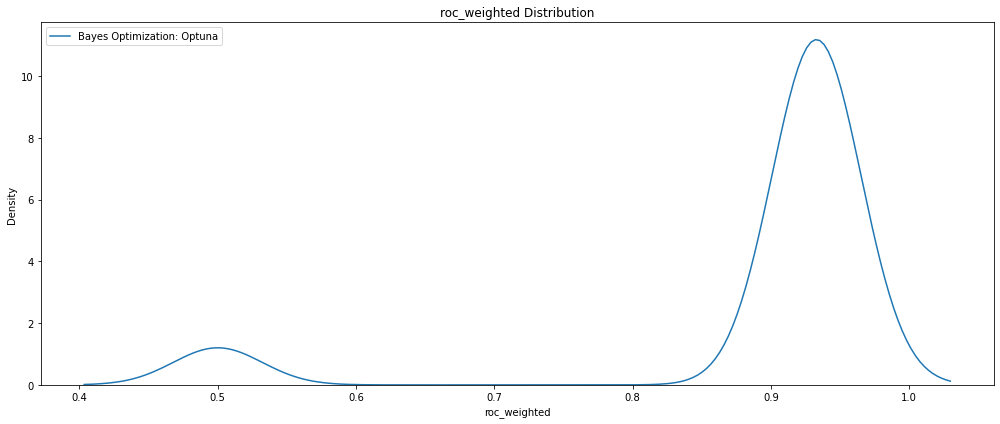

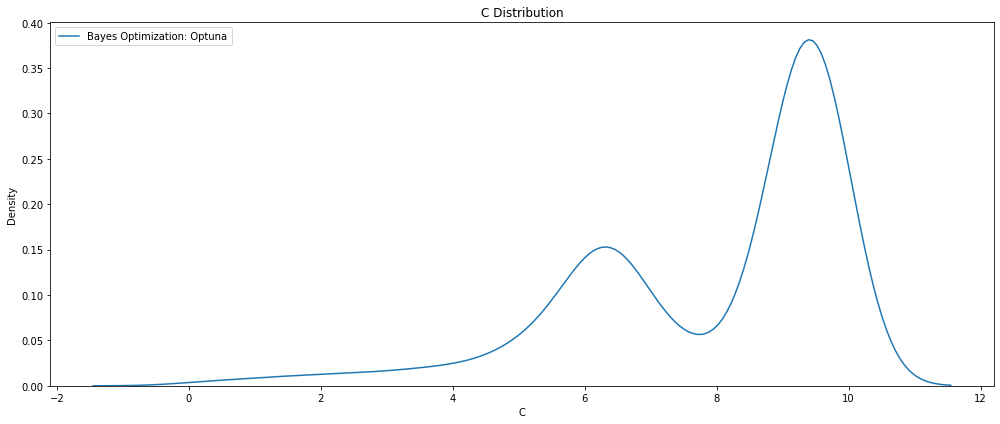

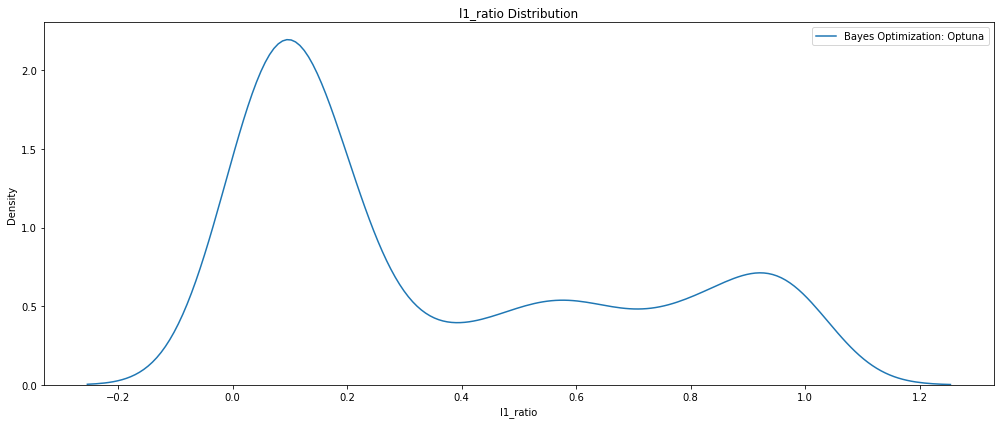

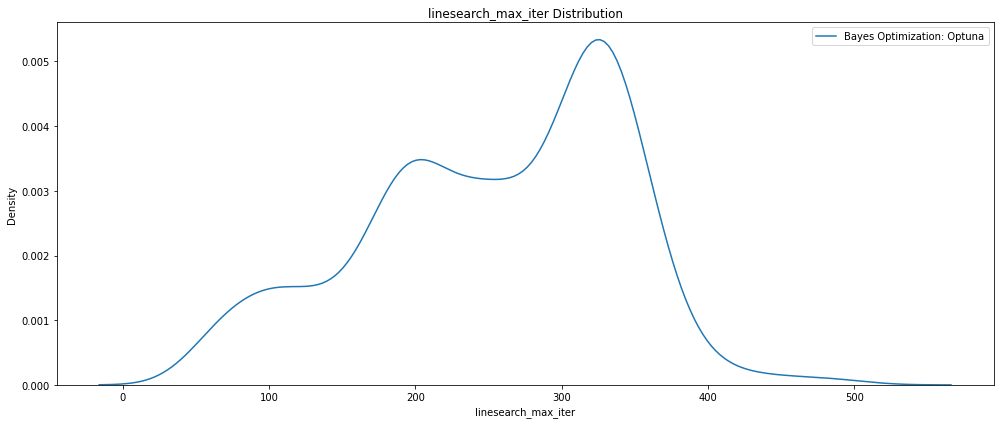

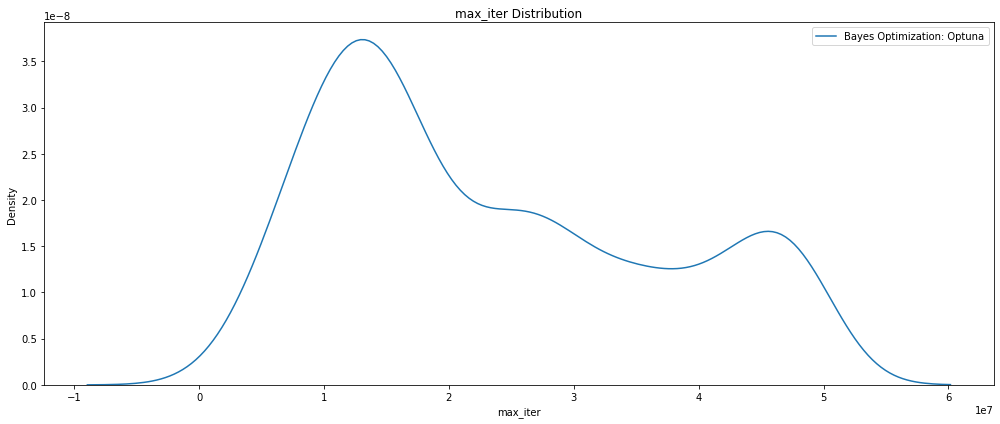

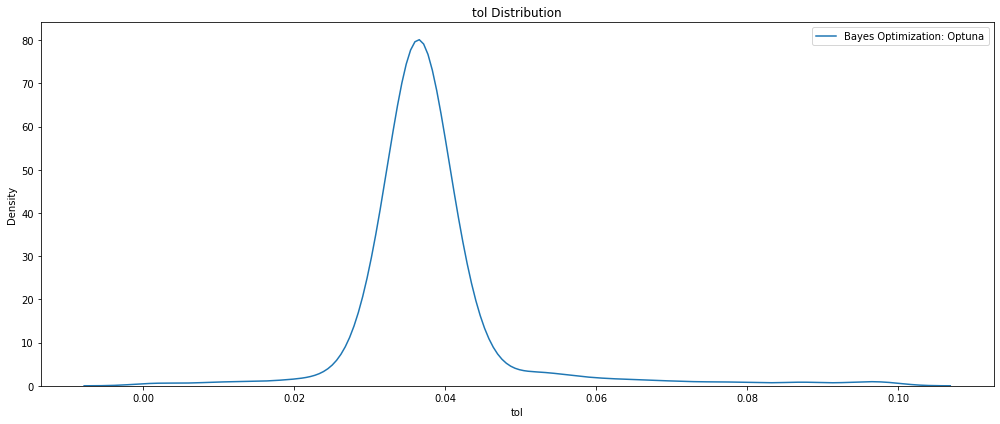

In [106]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [107]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_US_1000_GPU_ROCweighted.html')
fig.show()

In [108]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_US_1000_GPU_ROCweighted.html')
fig.show()

In [109]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 6.4,
 'l1_ratio': 0.9873827946567323,
 'linesearch_max_iter': 79,
 'max_iter': 15536062,
 'penalty': 'l1',
 'tol': 0.03671495015853522}

In [110]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [111]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [112]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)
    
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [113]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [114]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_US_trials1000_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_US_trials1000_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [115]:
print('\nModel Metrics for Logistic HPO Upsampling 1000 trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO Upsampling 1000 trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    377848
           1       0.78      0.90      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.88      0.93      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[364011  13837]
 [  5310  49315]]


Accuracy score : 0.956
Precision score : 0.781
Recall score : 0.903
F1 score : 0.837


In [116]:
# Evaluate on the testing data 
print('The best model from Upsampling 1000 GPU ROCweighted trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 1000 GPU ROCweighted trials optimization scores 0.93309 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     450
roc_weighted                             0.933086
datetime_start         2022-07-02 23:42:17.587332
datetime_complete      2022-07-02 23:42:19.402889
duration                   0 days 00:00:01.815557
C                                             9.3
l1_ratio                                 0.187124
linesearch_max_iter                         323.0
max_iter                               27718225.0
penalty                                        l1
tol                                      0.036287
state                                    COMPLETE
Name: 450, dtype: object


In [117]:
################################################################################
######################         Recall Score       ##############################
######################         1000 Trials        ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_lr_optuna_US_1000_Recall_tpe'

In [118]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [120]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=10000, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall of the fitted model
    '''    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    
    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                   C=C, max_iter=max_iter, linesearch_max_iter=linesearch_max_iter, 
                   l1_ratio=l1_ratio, solver=solver, 
                   fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = recall_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial recall score:', score)
    print('######################################################')

    return score

In [121]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 7.270151190001343
- Trial recall score: 0.8826361556064073
######################################################
Score with default parameters :  0.8826361556064073


In [122]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Logistic_Optuna_US_1000_GPU_Recall.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)       
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [123]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_US_1000_GPU_Recall.pkl'): 
        study = joblib.load('Logistic_Optuna_US_1000_GPU_Recall.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall', study.best_value)

Start Time           2022-07-03 00:13:50.343132
- Trial time: 1.188768660000278
- Trial recall score: 0.9028466819221967
######################################################
- Trial time: 1.19133818499904
- Trial recall score: 0.9028466819221967
######################################################
- Trial time: 1.1861180140003853
- Trial recall score: 0.9028466819221967
######################################################
- Trial time: 1.1802433709999605
- Trial recall score: 0.9028466819221967
######################################################
- Trial time: 1.1752421429991955
- Trial recall score: 0.9028466819221967
######################################################
- Trial time: 1.1810308610001812
- Trial recall score: 0.9028466819221967
######################################################
- Trial time: 0.29138859900012903
- Trial recall score: 0.0
######################################################
- Trial time: 1.1700946539986035
- Trial recall score: 0.902846681

In [124]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [125]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

trials_df = trials_df.sort_values('recall', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Logistic_Optuna_US_1000_GPU_Recall.csv', index=False)

      iteration    recall             datetime_start  \
1254       1254  0.902865 2022-07-03 00:39:53.555918   
1270       1270  0.902865 2022-07-03 00:40:25.472584   
1085       1085  0.902865 2022-07-03 00:34:19.652628   
1083       1083  0.902865 2022-07-03 00:34:15.859460   
1202       1202  0.902865 2022-07-03 00:38:06.228476   
...         ...       ...                        ...   
864         864  0.000000 2022-07-03 00:27:31.782463   
880         880  0.000000 2022-07-03 00:28:04.017791   
887         887  0.000000 2022-07-03 00:28:16.103490   
1375       1375  0.000000 2022-07-03 00:43:58.950291   
375         375       NaN 2022-07-03 00:11:24.555486   

              datetime_complete               duration     C  l1_ratio  \
1254 2022-07-03 00:39:55.544421 0 days 00:00:01.988503   1.6  0.299515   
1270 2022-07-03 00:40:27.455659 0 days 00:00:01.983075   1.2  0.344778   
1085 2022-07-03 00:34:21.550393 0 days 00:00:01.897765   1.2  0.387562   
1083 2022-07-03 00:34:17.761877

In [126]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [127]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_US_1000_GPU_Recall.html')
fig.show()

In [128]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_US_1000_GPU_Recall.html')
fig.show()

In [129]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_US_1000_GPU_Recall.html')
fig.show()

In [130]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_US_1000_GPU_Recall.html')
fig.show()

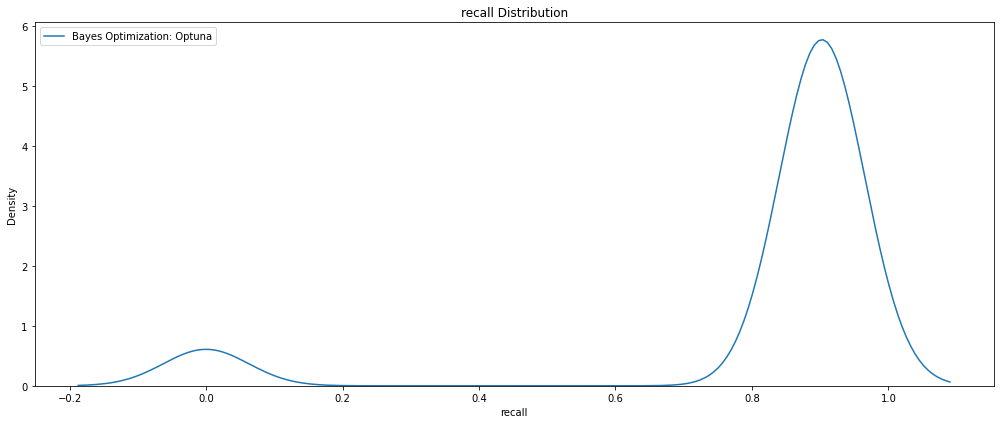

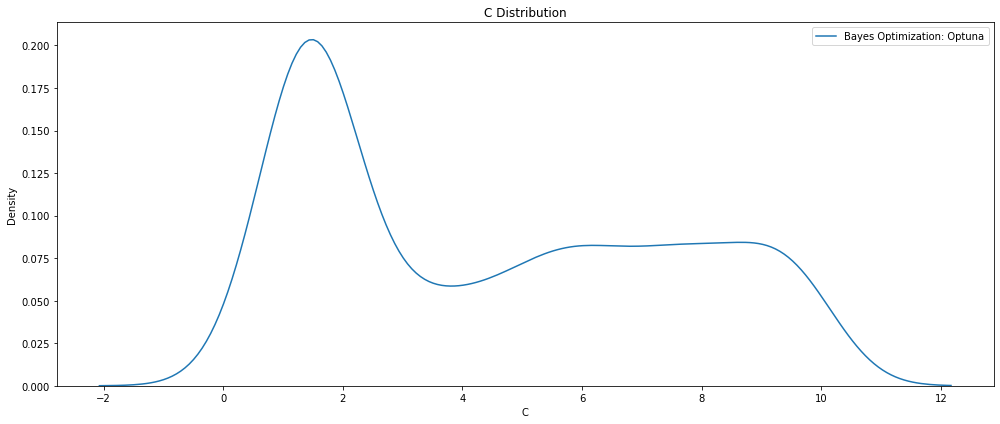

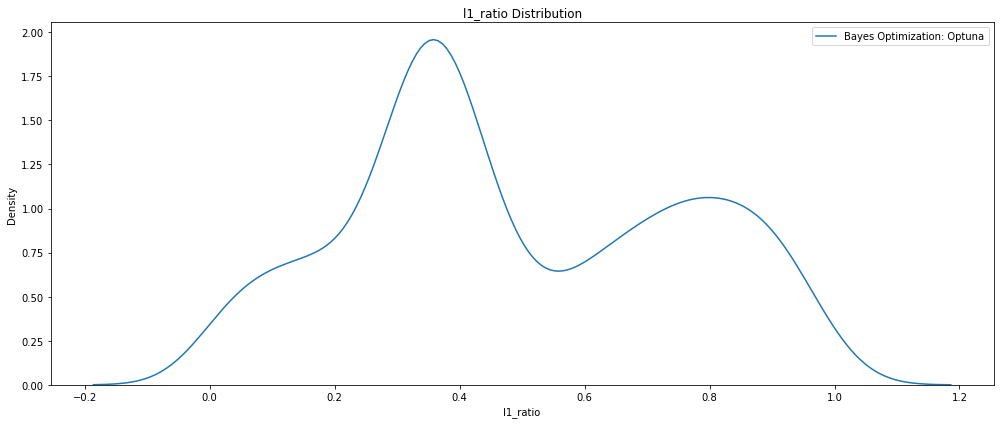

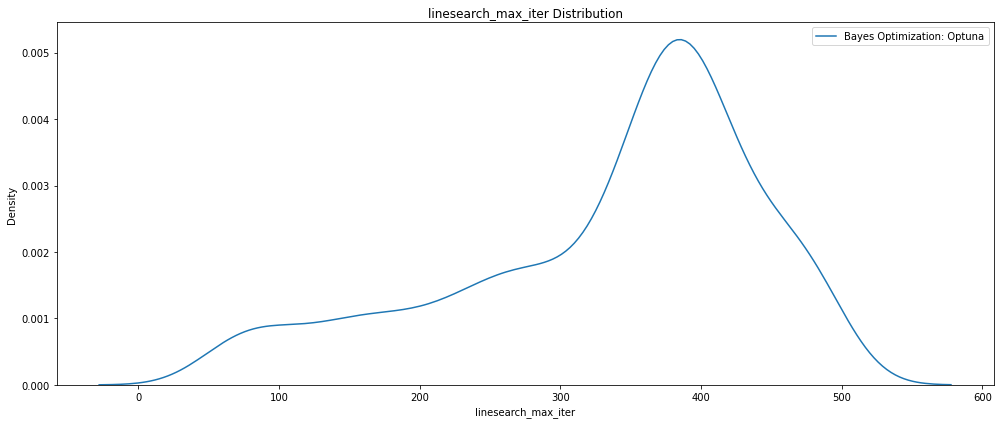

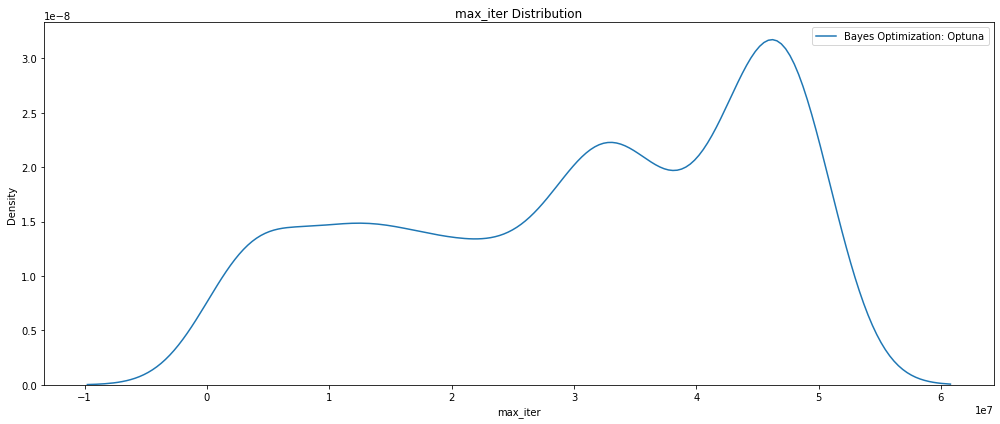

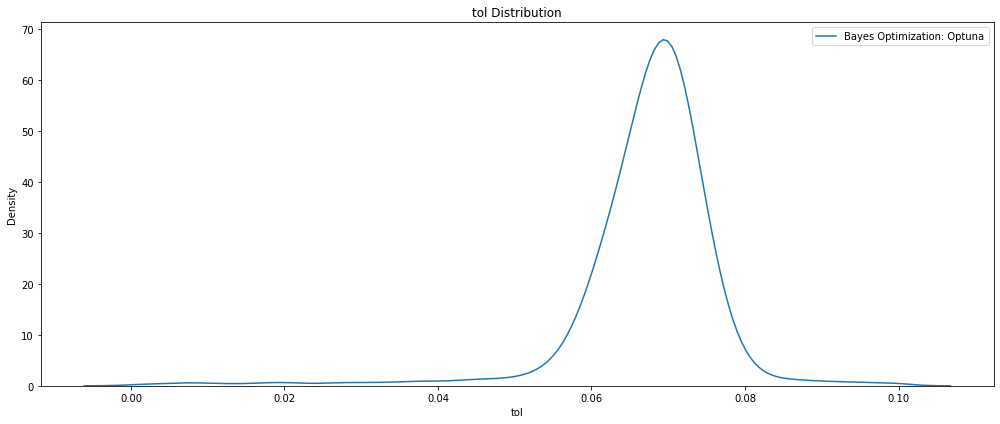

In [132]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [133]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_US_1000_GPU_Recall.html')
fig.show()

In [134]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_US_1000_GPU_Recall.html')
fig.show()

In [135]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 1.6,
 'l1_ratio': 0.16266597947632436,
 'linesearch_max_iter': 78,
 'max_iter': 11766297,
 'penalty': 'l1',
 'tol': 0.07074582447852408}

In [136]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [137]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [138]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)
    
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [139]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [140]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_US_trials1000_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_US_trials1000_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [141]:
print('\nModel Metrics for Logistic HPO Upsampling 1000 trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO Upsampling 1000 trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    377848
           1       0.78      0.90      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.88      0.93      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[363982  13866]
 [  5306  49319]]


Accuracy score : 0.956
Precision score : 0.781
Recall score : 0.903
F1 score : 0.837


In [142]:
# Evaluate on the testing data 
print('The best model from Upsampling 1000 GPU Recall trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 1000 GPU Recall trials optimization scores 0.93308 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    1254
recall                                   0.902865
datetime_start         2022-07-03 00:39:53.555918
datetime_complete      2022-07-03 00:39:55.544421
duration                   0 days 00:00:01.988503
C                                             1.6
l1_ratio                                 0.299515
linesearch_max_iter                         409.0
max_iter                               49943400.0
penalty                                        l1
tol                                      0.067249
state                                    COMPLETE
Name: 1254, dtype: object


In [143]:
################################################################################
######################        Precision Score     ##############################
######################         1000 Trials        ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_lr_optuna_US_1000_Precision_tpe'

In [144]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [145]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=1e6, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision of the fitted model
    '''    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    
    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                   C=C, max_iter=max_iter, linesearch_max_iter=linesearch_max_iter, 
                   l1_ratio=l1_ratio, solver=solver, 
                   fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    score = precision_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Precision score:', score)
    print('######################################################')
    
    return score

In [146]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 7.424560385999939
- Trial Precision score: 0.8211949856928736
######################################################
Score with default parameters :  0.8211949856928736


In [147]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Logistic_Optuna_US_1000_GPU_Precision.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)        
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [148]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_US_1000_GPU_Precision.pkl'): 
        study = joblib.load('Logistic_Optuna_US_1000_GPU_Precision.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision', study.best_value)

Start Time           2022-07-03 00:56:19.650756
- Trial time: 0.3010102799999004
- Trial Precision score: 0.0
######################################################
- Trial time: 0.2900030210003024
- Trial Precision score: 0.0
######################################################
- Trial time: 0.2914987089989154
- Trial Precision score: 0.0
######################################################
- Trial time: 0.29419598400090763
- Trial Precision score: 0.0
######################################################
- Trial time: 1.1982217059994582
- Trial Precision score: 0.7805951250395695
######################################################
- Trial time: 0.299025468999389
- Trial Precision score: 0.0
######################################################
- Trial time: 0.2919079069997679
- Trial Precision score: 0.0
######################################################
- Trial time: 0.30196430499927374
- Trial Precision score: 0.0
######################################################


In [149]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [150]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

trials_df = trials_df.sort_values('precision', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Logistic_Optuna_US_1000_GPU_Precision.csv', index=False)

     iteration  precision             datetime_start  \
91          91   0.919756 2022-07-03 01:03:15.737479   
66          66   0.858638 2022-07-03 01:00:37.056934   
359        359   0.855848 2022-07-03 01:32:20.906061   
286        286   0.823086 2022-07-03 01:24:46.680231   
427        427   0.822568 2022-07-03 01:39:48.324789   
..         ...        ...                        ...   
148        148   0.000000 2022-07-03 01:09:38.044222   
773        773   0.000000 2022-07-03 02:17:44.264361   
782        782   0.000000 2022-07-03 02:18:47.218723   
129        129   0.000000 2022-07-03 01:07:34.199314   
0            0   0.000000 2022-07-03 00:56:19.653210   

             datetime_complete               duration    C  l1_ratio  \
91  2022-07-03 01:03:45.672145 0 days 00:00:29.934666  3.8  0.828944   
66  2022-07-03 01:01:03.903332 0 days 00:00:26.846398  1.0  0.858148   
359 2022-07-03 01:32:39.993333 0 days 00:00:19.087272  4.5  0.764805   
286 2022-07-03 01:24:54.744829 0 days 0

In [151]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [152]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_US_1000_GPU_Precision.html')
fig.show()

In [154]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_US_1000_GPU_Precision.html')
fig.show()

In [153]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_US_1000_GPU_Precision.html')
fig.show()

In [155]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_US_1000_GPU_Precision.html')
fig.show()

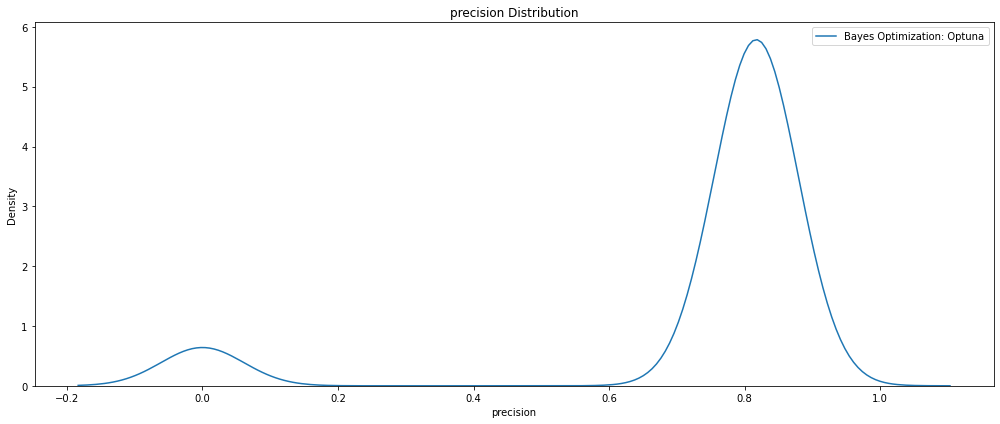

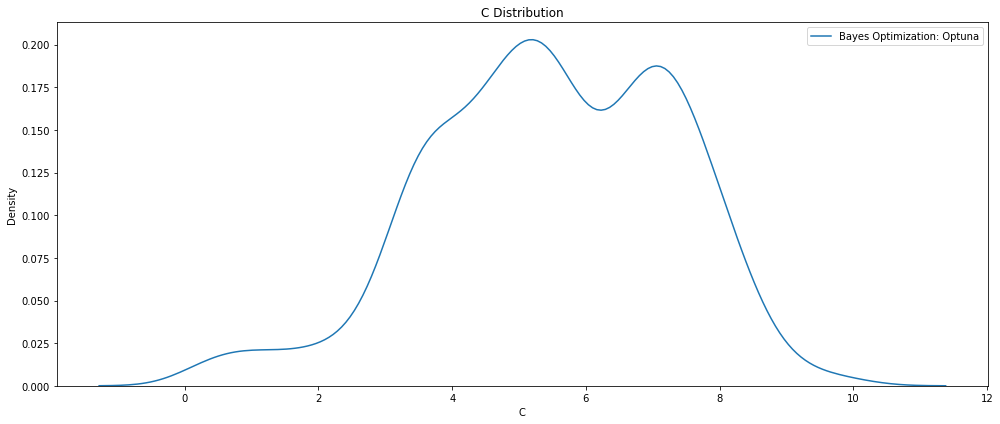

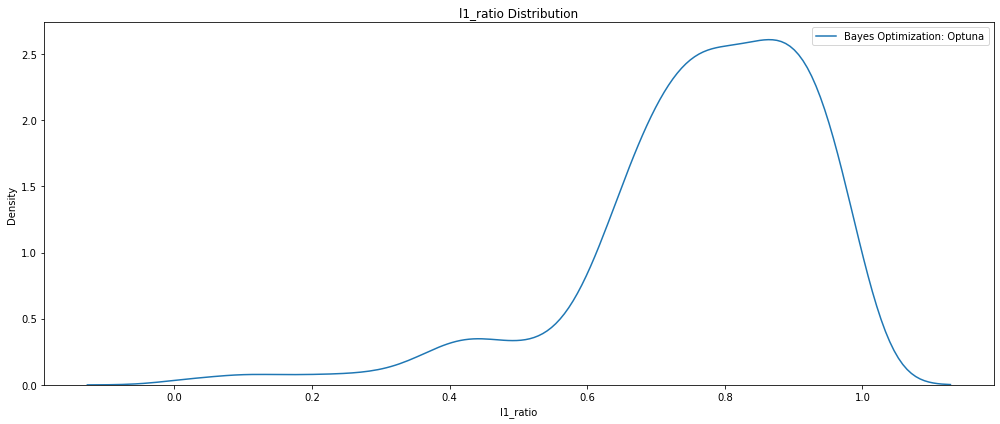

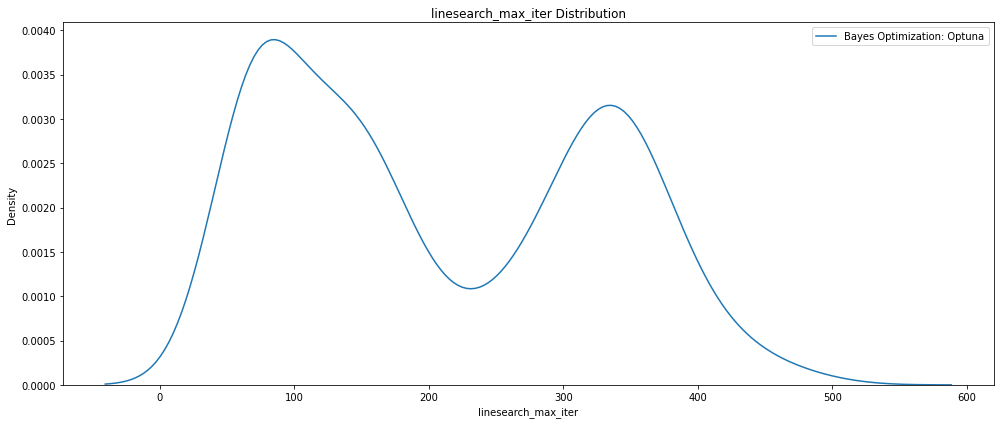

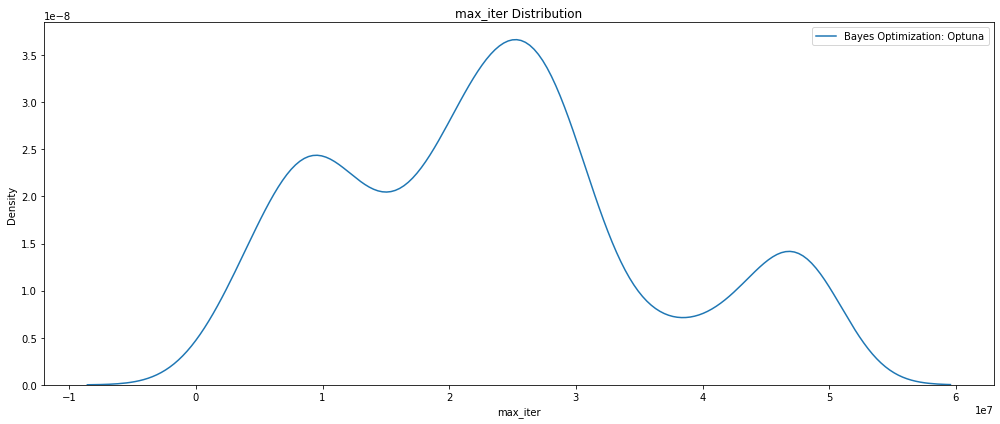

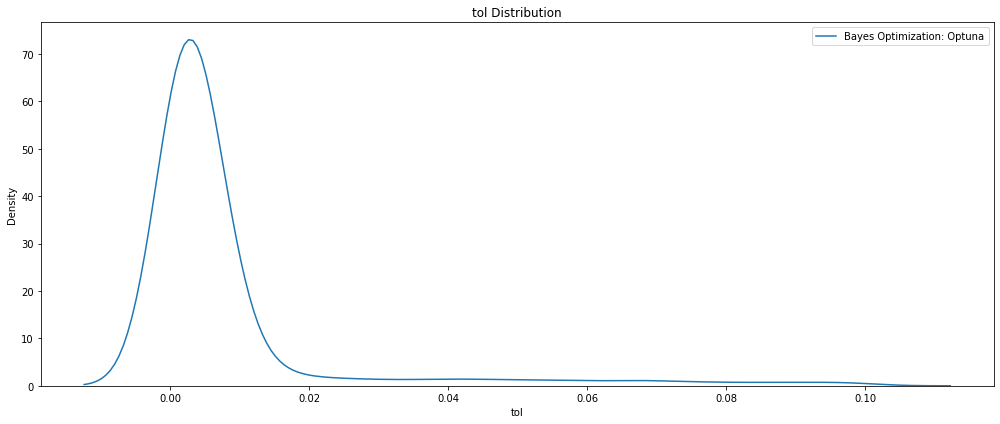

In [157]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [158]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_US_1000_GPU_Precision.html')
fig.show()

In [159]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_US_1000_GPU_Precision.html')
fig.show()

In [160]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params

{'C': 3.8000000000000003,
 'l1_ratio': 0.828944372376544,
 'linesearch_max_iter': 269,
 'max_iter': 28117914,
 'penalty': 'l1',
 'tol': 2.3999510896064846e-05}

In [161]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [162]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [163]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)
    
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [164]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [165]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_US_trials1000_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_US_trials1000_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [166]:
print('\nModel Metrics for Logistic HPO Upsampling 1000 trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO Upsampling 1000 trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    377848
           1       0.82      0.88      0.85     54625

    accuracy                           0.96    432473
   macro avg       0.90      0.93      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[367407  10441]
 [  6430  48195]]


Accuracy score : 0.961
Precision score : 0.822
Recall score : 0.882
F1 score : 0.851


In [167]:
# Evaluate on the testing data 
print('The best model from Upsampling 1000 GPU Precision trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 1000 GPU Precision trials optimization scores 0.92733 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      91
precision                                0.919756
datetime_start         2022-07-03 01:03:15.737479
datetime_complete      2022-07-03 01:03:45.672145
duration                   0 days 00:00:29.934666
C                                             3.8
l1_ratio                                 0.828944
linesearch_max_iter                           269
max_iter                                 28117914
penalty                                        l1
tol                                      0.000024
state                                    COMPLETE
Name: 91, dtype: object
